In this notebook, we will integrate all the previously developed models to evaluate results on the testing data.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Modules**

In [2]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.1 MB/s eta 0:00:00


### **Importing custom modules**

In [3]:
import sys
import os

BASE_DIR = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation"
MODELS = os.path.join(BASE_DIR, "notebooks", "end_to_end", "modules", "models")
UTILS = os.path.join(BASE_DIR, "notebooks", "end_to_end", "modules", "utils")

sys.path.append(MODELS)
sys.path.append(UTILS)

In [8]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
from abc import ABC, abstractmethod


#models
from ultralytics import YOLO
from kpd_rgb_model import KeypointHeatmapNet
from kpd_rgb_depth_model import CrossFuNet
from kpd_depth_extended_model import CrossFuNetEnhanced

#yolo functions
from yolo_utils import crop_and_resize, plot_detection_and_crop

#kpd functions
from kpd_utils import extract_keypoints_to_original_image_space

#pnp functions
from pnp_utils import run_pnp

#add functions
from add_utils import evaluate_pose_estimation

### **Data paths**

In [15]:
#MODELS
YOLO_PATH = os.path.join(BASE_DIR, "models", "yolov10m", "weights", "best.pt")

#Baseline models with cps and fps
KPD_RGB_FPS_PATH = os.path.join(BASE_DIR,"models", "resnet", "resnet18_fps_model_50_keypoints_focalhm.pth")
KPD_RGB_CPS_PATH = os.path.join(BASE_DIR, "models", "resnet", "resnet18_cps_model_50_keypoints_focalhm.pth")

#Cross fusion model (extended)
KPD_RGBD_PATH = os.path.join(BASE_DIR, "models", "resnet", "best_resnet_fps_model_cross_fusion.pth")
KPD_RGBD_EX_PATH = os.path.join(BASE_DIR, "models","resnet", "resnet_full_data_with_all_extensions.pth")

#3D Points for performing PnP
KP3D_CPS_JSON = os.path.join(BASE_DIR, "data/point_sampling_data/3D_50_keypoints_cps.json")
KP3D_FPS_JSON = os.path.join(BASE_DIR, "data/point_sampling_data/3D_50_keypoints_fps.json")

#GT TEST DATA
GT_JSON = os.path.join(BASE_DIR, "data/full_data/test/gt.json")

#TEST_IMAGES
TEST_IMAGES = os.path.join(BASE_DIR, "data/full_data/test/images")

#DEPTH TEST IMAGES
TEST_DEPTH_IMAGES = os.path.join(BASE_DIR, "data/full_data/test/depth")

### **Models definition**

- RGBPoseEstimator - model that uses only RGB images

In [10]:
class RGBPoseEstimator:

    def __init__(self, yolo_model_path, kpd_model_path, kp3d_path, num_keypoints=50):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        #loading models on gpu -> for yolo it is by default
        self.yolo = YOLO(yolo_model_path)
        self.kpd = self.load_kpd(kpd_model_path, num_keypoints)
        self.kpd.to(self.device).eval()

        #loading 3D points needed for PnP
        self.kp3d_dict = self.load_3D_points(kp3d_path)

        #normalization needed for ResNet Network
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )

    #loading kpd
    def load_kpd(self, path, num_keypoints):
        model = KeypointHeatmapNet(num_keypoints=num_keypoints)
        state_dict = torch.load(path, map_location=self.device)
        model.load_state_dict(state_dict)
        return model

    #loading 3D points
    def load_3D_points(self, kp3d_path):
        with open(kp3d_path, "r") as f:
            kp3d_50 = json.load(f)
        return kp3d_50

    #YOLO functions
    def detect_object(self, image_path):
        print("Usao u yolo")
        return self.yolo(image_path)

    def get_bbox(self, result, index=0):
        box = result[0].boxes[index].xyxy[0].tolist()
        return list(map(int, box))

    #KPD functions
    def preprocess_image_for_kpd(self, image_path, bbox, size=(256, 256)):

        image = Image.open(image_path).convert("RGB")
        image_tensor = self.to_tensor(image)
        x1, y1, x2, y2 = bbox #msm da nema potrebe dradit ponovo map

        # Crop and resize
        crop = image_tensor[:, y1:y2, x1:x2]
        resized = torch.nn.functional.interpolate(
            crop.unsqueeze(0), size=size, mode="bilinear", align_corners=False
        )

        # Normalize for ResNet
        normalized = self.normalize(resized.squeeze(0)).unsqueeze(0).to(self.device)
        return normalized

    #KPD functions
    def detect_keypoints(self, image_path, bbox):
        image_tensor = self.preprocess_image_for_kpd(image_path, bbox)
        heatmaps = self.kpd(image_tensor)
        return heatmaps

    #Estimating pose for one picture
    def estimate_pose(self, image_path):

        #yolo outputs
        result = self.detect_object(image_path)
        bbox = self.get_bbox(result)

        #kpd outputs
        heatmaps = self.detect_keypoints(image_path, bbox)
        keypoints_2d = extract_keypoints_to_original_image_space(heatmaps, bbox)

        #taking only xx_xxxx.png
        img_id = image_path.split("/")[-1]
        obj_key, pose_result, inliers = run_pnp(img_id, keypoints_2d.tolist(), self.kp3d_dict)


        return img_id.split(".")[0], pose_result, inliers


    #If we want to perform evaluation, process is paralelized
    def __paralelized_estimate_pose(self, image_paths):

      def process_image(img_path):
          try:
              img_id, pose_result, inliers = self.estimate_pose(img_path)
              if pose_result is not None:
                  return img_id, pose_result, inliers
          except Exception as e:
              print(f"Error processing {img_path}: {e}")
          return None

      pnp_results = {}
      skipped = []

      # Use ThreadPoolExecutor for parallel inference
      with ThreadPoolExecutor(max_workers=4) as executor:
          futures = {executor.submit(process_image, img_path): img_path for img_path in image_paths}
          for future in as_completed(futures):

              result = future.result()
              if result:
                  img_id, pose_result, inliers = result
                  pnp_results[img_id] = (pose_result, inliers)
              else:
                  img_path = futures[future]
                  skipped.append()

      return pnp_results, skipped


    #method for evaluation of test data
    def evaluate(self, image_paths, GT_JSON, diameter_map, symmetric_objects, threshold_ratio=0.1, debug=False):

        with open(GT_JSON, "r") as f:
            gt_data = json.load(f)

        pnp_results, skipped = self.__paralelized_estimate_pose(image_paths)

        if debug:
            print(f"[INFO] Processed {len(pnp_results)} images.")
            print(f"[INFO] Example keys: {list(pnp_results.keys())[:5]}")
            print(f"[INFO] Number of skipped examples: {len(skipped)}")

        accuracy_results, results_distribution_class, high_error_samples = evaluate_pose_estimation(
            pnp_results=pnp_results,
            kp3d=self.kp3d_dict,
            gt_data=gt_data,
            diameter_map=diameter_map,
            symmetric_objects=symmetric_objects,
            threshold_ratio=threshold_ratio
        )

        return accuracy_results, results_distribution_class, high_error_samples

- RGBDepthPoseEstimator - model that uses RGB and depth images

In [11]:
class RGBDPoseEstimator:

    def __init__(self, yolo_model_path, kpd_model_path, kpd_class, kp3d_path, num_keypoints=50):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        #loading models on gpu -> for yolo it is by default
        self.yolo = YOLO(yolo_model_path)
        self.kpd = self.load_kpd(kpd_model_path, kpd_class, num_keypoints)
        self.kpd.to(self.device).eval()

        #loading 3D points needed for PnP
        self.kp3d_dict = self.load_3D_points(kp3d_path)

        #normalization needed for ResNet Network
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )

    #loading kpd
    def load_kpd(self, path, kpd_class, num_keypoints):
        model = kpd_class(num_keypoints=num_keypoints) #Model with DEPTH
        state_dict = torch.load(path, map_location=self.device)
        model.load_state_dict(state_dict, strict = False)
        return model

    #loading 3D points
    def load_3D_points(self, kp3d_path): #SAME
        with open(kp3d_path, "r") as f:
            kp3d_50 = json.load(f)
        return kp3d_50

    #YOLO functions
    def detect_object(self, image_path): #SAME
        return self.yolo(image_path)

    def get_bbox(self, result, index=0): #SAME
        box = result[0].boxes[index].xyxy[0].tolist()
        return list(map(int, box))


    #KPD functions
    def preprocess_image_for_kpd(self, image_path, bbox, size=(256, 256)):

        image = Image.open(image_path).convert("RGB")
        image_tensor = self.to_tensor(image)
        x1, y1, x2, y2 = bbox #msm da nema potrebe dradit ponovo map

        # Crop and resize
        crop = image_tensor[:, y1:y2, x1:x2]
        resized = torch.nn.functional.interpolate(
            crop.unsqueeze(0), size=size, mode="bilinear", align_corners=False
        )

        # Normalize for ResNet
        normalized = self.normalize(resized.squeeze(0)).unsqueeze(0).to(self.device)

        return normalized


    def preprocess_depth_image_for_kpd(self, depth_path, bbox, size=(256, 256)):

        #open depth image
        depth_img = Image.open(depth_path)
        depth_np = np.array(depth_img).astype(np.float32)  # [H, W]

        #normalize it for resnet
        depth_np = (depth_np - 500.0) / 1000.0
        depth_np = np.clip(depth_np, 0.0, 1.0)

        depth_tensor = torch.from_numpy(depth_np).unsqueeze(0)

        # crop by bounding box
        x1, y1, x2, y2 = bbox
        depth_crop = depth_tensor[:, y1:y2, x1:x2]

        # rescale to 256x256
        resized = torch.nn.functional.interpolate(
            depth_crop.unsqueeze(0), size=size, mode="bilinear", align_corners=False
        )  # [1, 1, H, W]


        # only 1 channe not like RGB!!!
        return resized.to(self.device)

    #KPD functions
    def detect_keypoints(self, image_path, depth_path, bbox):  #A bit different

        image_tensor = self.preprocess_image_for_kpd(image_path, bbox)
        depth_tensor = self.preprocess_depth_image_for_kpd(depth_path, bbox)
        heatmaps = self.kpd(image_tensor, depth_tensor)
        return heatmaps


    #Estimating pose for one picture
    def estimate_pose(self, image_path, depth_path):

        #yolo outputs
        result = self.detect_object(image_path)
        bbox = self.get_bbox(result)

        #kpd outputs
        heatmaps = self.detect_keypoints(image_path, depth_path, bbox)
        keypoints_2d = extract_keypoints_to_original_image_space(heatmaps, bbox)

        #taking only xx_xxxx.png
        img_id = image_path.split("/")[-1]
        obj_key, pose_result, inliers = run_pnp(img_id, keypoints_2d.tolist(), self.kp3d_dict)


        return img_id.split(".")[0], pose_result, inliers


    #If we want to perform evaluation, process is paralelized
    def __paralelized_estimate_pose(self, image_paths, depth_paths):

      def process_image(img_path, depth_path):
          try:
              img_id, pose_result, inliers = self.estimate_pose(img_path, depth_path)
              if pose_result is not None:
                  return img_id, pose_result, inliers
          except Exception as e:
              print(f"Error processing {img_path}: {e}")
          return None

      pnp_results = {}
      skipped = []

      # Use ThreadPoolExecutor for parallel inference
      with ThreadPoolExecutor(max_workers=4) as executor:
          futures = {}
          # we send sorted paths
          for i, img_path in enumerate(image_paths):

              depth_path = depth_paths[i]
              futures[executor.submit(process_image, img_path, depth_path)] = img_path

          for future in as_completed(futures):
              result = future.result()
              if result:
                  img_id, pose_result, inliers = result
                  pnp_results[img_id] = (pose_result, inliers)
              else:
                  img_path = futures[future]
                  skipped.append(img_path)

      return pnp_results, skipped


    #method for evaluation of test data
    def evaluate(self, image_paths, depth_paths, GT_JSON, diameter_map, symmetric_objects, threshold_ratio=0.1, debug=False):

        with open(GT_JSON, "r") as f:
            gt_data = json.load(f)

        pnp_results, skipped = self.__paralelized_estimate_pose(image_paths, depth_paths)

        if debug:
            print(f"[INFO] Processed {len(pnp_results)} images.")
            print(f"[INFO] Example keys: {list(pnp_results.keys())[:5]}")
            print(f"[INFO] Number of skipped examples: {len(skipped)}")

        accuracy_results, results_distribution_class, high_error_samples = evaluate_pose_estimation(
            pnp_results=pnp_results,
            kp3d=self.kp3d_dict,
            gt_data=gt_data,
            diameter_map=diameter_map,
            symmetric_objects=symmetric_objects,
            threshold_ratio=threshold_ratio
        )

        return accuracy_results, results_distribution_class, high_error_samples

# **Evaluation part**

## **Evaluating RGBPoseEstimator with FPS-generated 3D keypoints**

- Function for plotting results

In [12]:
def plot_accuracies(results_dict):
    # Calculate mean accuracy
    mean_acc = sum(results_dict.values()) / len(results_dict)

    # Plotting
    plt.figure(figsize=(12, 7))
    bars = plt.bar(results_dict.keys(), results_dict.values())  # Removed label here

    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Plot mean line
    plt.axhline(mean_acc, color='red', linestyle='--', linewidth=2,
                label=f'Mean Accuracy = {mean_acc:.2f}%')

    # Labels and title with larger font size
    plt.xlabel('Class ID', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.title('Accuracies by Class ID with Mean', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.15), fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### **Data definition**

In [13]:
test_images = sorted(os.listdir(TEST_IMAGES))
depth_images  = sorted(os.listdir(TEST_DEPTH_IMAGES))
diameter_map = {
    '01': 102.09865663,
    '02': 247.50624233,
    '03': 167.35486092,
    '04': 172.49224865,
    '05': 201.40358597,
    '06': 154.54551808,
    '07': 124.26430816,
    '08': 261.47178102,
    '09': 108.99920102,
    '10': 164.62758848,
    '11': 175.88933422,
    '12': 145.54287471,
    '13': 278.07811733,
    '14': 282.60129399,
    '15': 212.35825148
}

symmetric_objects = {'10', '11'}  #eggbox (10) and glue (11) are symmetric objects in linemod dataset
image_paths = [f"{TEST_IMAGES}/{image}"for image in test_images]
depth_paths = [f"{TEST_DEPTH_IMAGES}/{depth_image}"for depth_image in depth_images]

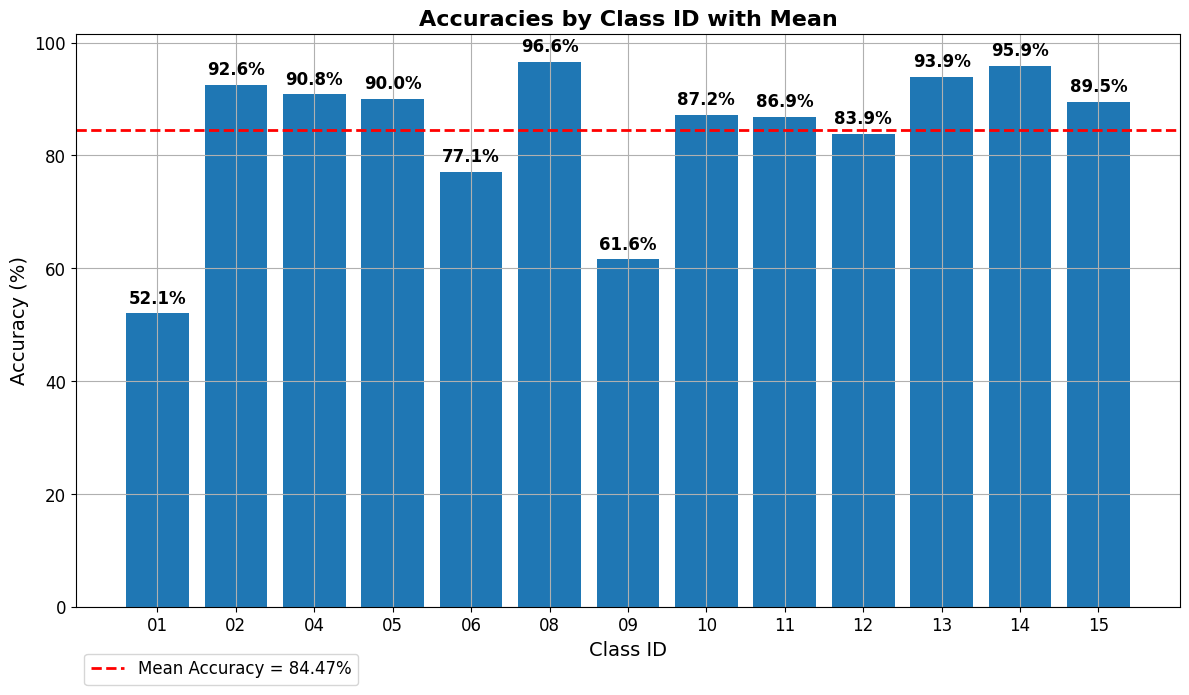

In [ ]:
pose_estimator = RGBPoseEstimator(YOLO_PATH, KPD_RGB_FPS_PATH, KP3D_FPS_JSON)
accuracy_fps, distribution_fps, bad_cases_fps = pose_estimator.evaluate(image_paths, GT_JSON, diameter_map, symmetric_objects)
plot_accuracies(accuracy_fps)

## **Evaluating RGBPoseEstimator with CPS-generated 3D keypoints**

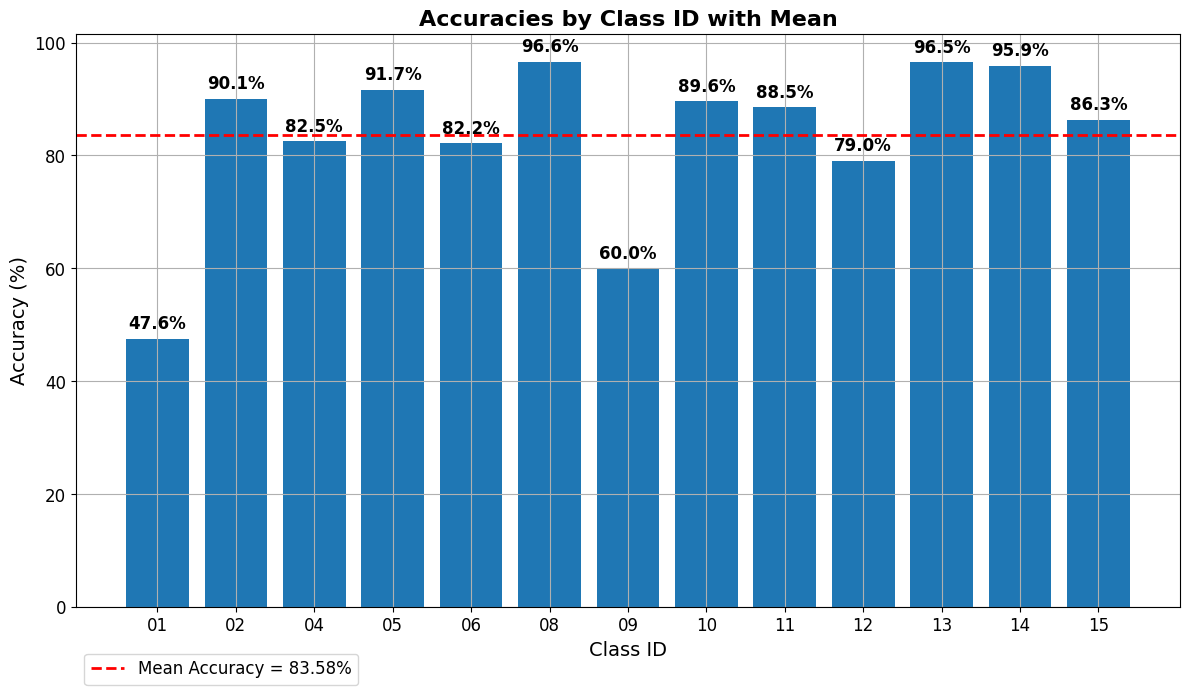

In [ ]:
pose_estimator_cps = RGBPoseEstimator(YOLO_PATH, KPD_RGB_CPS_PATH, KP3D_CPS_JSON)
image_paths = [f"{TEST_IMAGES}/{image}"for image in test_images]
accuracy_cps, distribution_cps, bad_cases_cps = pose_estimator_cps.evaluate(image_paths, GT_JSON, diameter_map, symmetric_objects)
plot_accuracies(accuracy_cps)

## **Evaluating RGBDepthPoseEstimator with FPS-generated 3D keypoints**

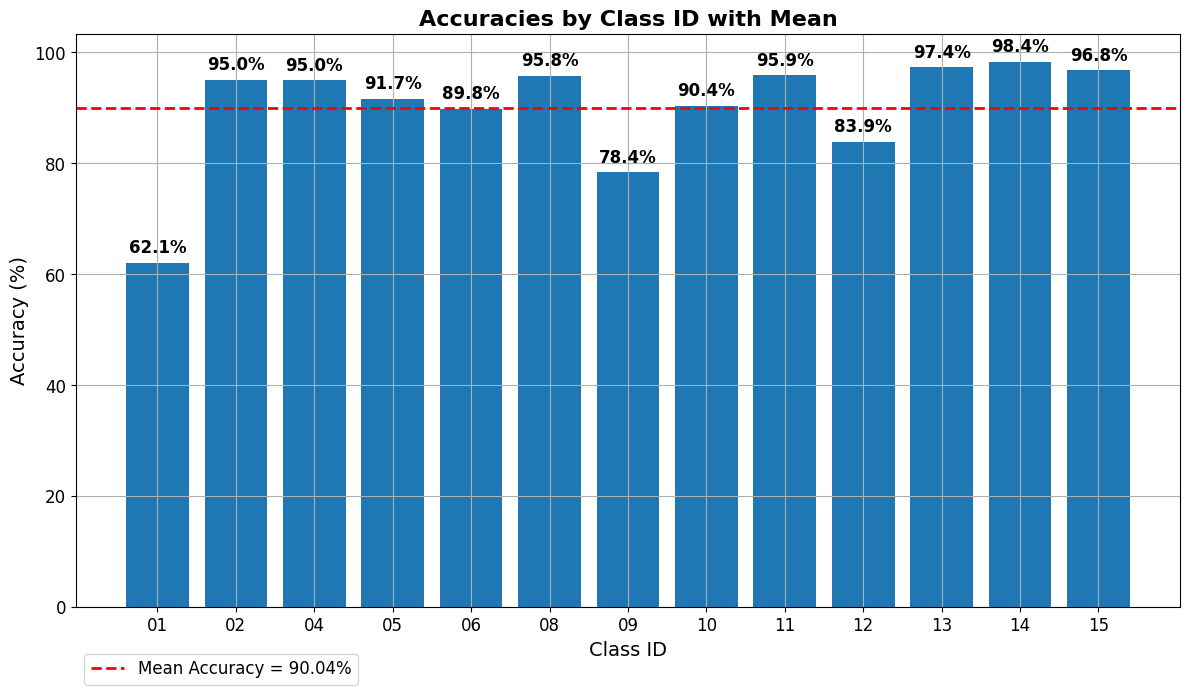

In [ ]:
pose_estimator = RGBDPoseEstimator(YOLO_PATH, KPD_RGBD_PATH, KP3D_FPS_JSON)
accuracy_depth, distribution, bad_cases = pose_estimator.evaluate(image_paths, depth_pathhttps://colab.research.google.com/drive/1cuhrUCIZawwyWaP2Bu24STJAOsW6zgD3?authuser=2#scrollTo=Jqx2eJRxjvsbs, GT_JSON, diameter_map, symmetric_objects)
plot_accuracies(accuracy_depth)

## **Evaluating RGBDepthPoseEstimator Using FPS-Generated 3D Keypoints with SiLU Activation and Adaptive Learning Rate**



Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Error processing /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/test/images/01_0013.png: 'Conv' object has no attribute 'bn'

Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,320,695 parameters, 0 gradients, 58.9 GFLOPs
YOLOv10m summary (fused): 136 layers, 15,320,695 parameters, 0 gradients, 58.9 GFLOPs
YOLOv10m summary (fused): 136 layers, 15,320,695 parameters, 0 gradients, 58.9 GFLOPs
YOLOv10m summary (fused): 136 layers, 15,320,695 parameters, 0 gradients, 58.9 GFLOPs
image 1/1 /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/test/images/01_0021.png: 480x640 1 ape, 95.4ms
Speed: 8.1ms preprocess, 95.4ms inference, 96.1ms postprocess

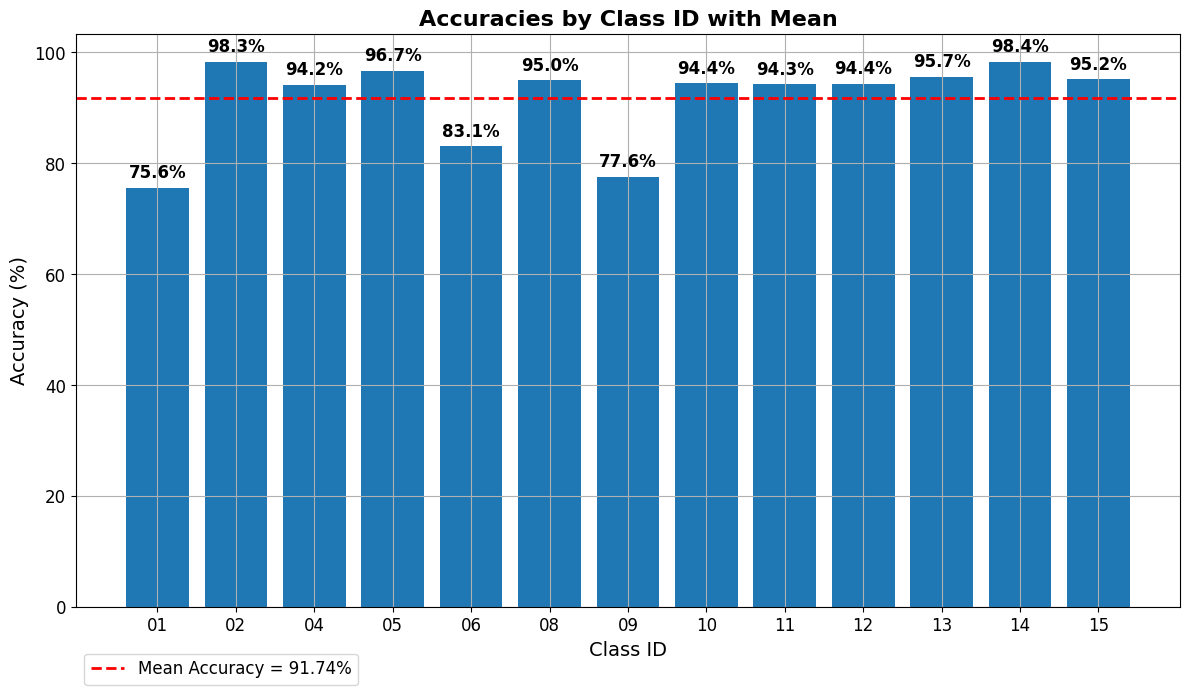

In [16]:
pose_estimator = RGBDPoseEstimator(YOLO_PATH, KPD_RGBD_EX_PATH, CrossFuNetEnhanced, KP3D_FPS_JSON)
accuracy_depth_enh, distribution_enh, bad_cases_enh = pose_estimator.evaluate(image_paths, depth_paths, GT_JSON, diameter_map, symmetric_objects)
plot_accuracies(accuracy_depth_enh)